In [132]:
import biom
import pandas as pd
import numpy as np
from skbio import TreeNode
from GCN_model import GCNEClassifier

import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [215]:
def gaussian_kernel(d, rho=2):
    """
    weight = exp(-2 * ρ * d^2)
    """
    return np.exp(-2 * rho * d ** 2)

In [148]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42, verbose=1)

In [113]:
taxonomy = pd.read_csv("/beegfs/db/greengenes/gg_13_8_otus/taxonomy/99_otu_taxonomy.txt", sep="\t", header=None)

In [124]:
taxonomy_split = taxonomy[1].str.split(';', expand=True)
taxonomy_split.columns = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
taxonomy_split.index = taxonomy.iloc[:, 0].values.astype("str")

In [128]:
taxonomy_split.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
228054,k__Bacteria,p__Cyanobacteria,c__Synechococcophycideae,o__Synechococcales,f__Synechococcaceae,g__Synechococcus,s__
228057,k__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Pelagibacteraceae,g__,s__
73627,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Actinomycetales,f__Mycobacteriaceae,g__Mycobacterium,s__
378462,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Staphylococcaceae,g__Staphylococcus,s__
89370,k__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae,g__Anoxybacillus,s__kestanbolensis


In [82]:
phylogeny_file_path = "/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_16S_IBD/phylogeny_normalize.nwk"
tree = TreeNode.read(phylogeny_file_path)

In [84]:
all_nodes_in_tree = list(tree.traverse(self_before=True))
node_to_idx = {node.name:i for i, node in enumerate(all_nodes_in_tree)}

In [95]:
idx_to_node = {}
for key, value in node_to_idx.items():
    idx_to_node[value] = key

In [163]:
model = GCNEClassifier(in_channels=32, hidden_channels=100, num_nodes=len(all_nodes_in_tree),
                       num_classes=2, num_layers=4, dropout_rate=0.1, residual='mean',
                       ffn=True, norm_type='batch_norm', act='relu',
                       readout='mean')

In [165]:
model.load_state_dict(torch.load("/home/dongbiao/GCN/data/IBD_16S/results/1_test_model.pt", map_location='cpu'))

<All keys matched successfully>

In [99]:
table = biom.load_table("/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_16S_IBD/data/train_1.biom")
fid = table.ids(axis="observation")

In [179]:
nodes_name = [idx_to_node[i] for i in range(0, len(all_nodes_in_tree))]
embedding_df = pd.DataFrame(data = model.embedding.weight.data.numpy(), index=nodes_name)
embedding_df = embedding_df.loc[fid]

In [189]:
X_embedded = tsne.fit_transform(embedding_df.values)
X_embedded = pd.DataFrame(data = X_embedded, index=embedding_df.index.values, columns=["PC1", "PC2"])
X_embedded = pd.concat([X_embedded, taxonomy_split.loc[X_embedded.index.values]], axis=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 416 samples in 0.001s...
[t-SNE] Computed neighbors for 416 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 416 / 416
[t-SNE] Mean sigma: 2.009004
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.301395
[t-SNE] KL divergence after 1000 iterations: 1.848705


In [191]:
import pandas as pd
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(embedding_df.values)
X_embedded = pd.DataFrame(
    data=X_pca, 
    index=embedding_df.index.values, 
    columns=["PC1", "PC2"]
)
X_embedded = pd.concat([X_embedded, taxonomy_split.loc[X_embedded.index.values]], axis=1)

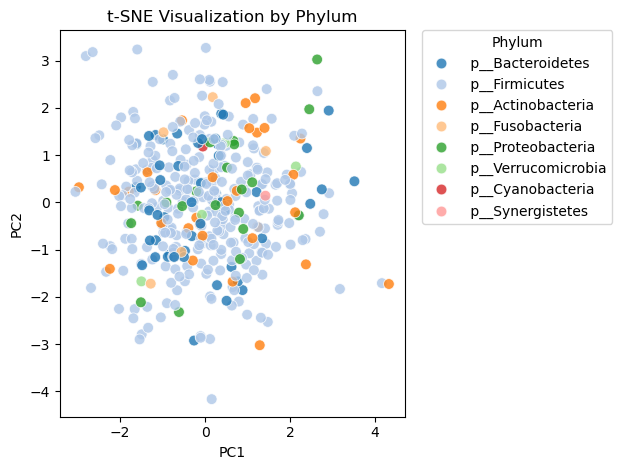

In [192]:
sns.scatterplot(
    data=X_embedded, 
    x='PC1', 
    y='PC2', 
    hue='Phylum', 
    palette='tab20',  
    s=60, 
    alpha=0.8
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Phylum')

plt.title('t-SNE Visualization by Phylum')
plt.tight_layout()
plt.show()

### Biomarker

In [332]:
def propagate_importance_top_down(full_tree, node_names, base_importance_scores, rho=2):
    """
    自顶向下（Root -> Leaf）传播特征重要性。
    子节点的最终重要性 = 自身的基础重要性 + (父节点的最终重要性 * 衰减系数)
    
    Args:
        full_tree (skbio.TreeNode): 系统发育树对象
        node_names (list): 所有节点的名称列表（顺序对应 base_importance_scores）
        base_importance_scores (np.array): GCN 计算出的原始梯度值
        rho (float): 高斯核函数的参数
        
    Returns:
        np.array: 传播后的最终重要性分数 (顺序与输入的 node_names 一致)
    """

    name_to_base_ig = {name: score for name, score in zip(node_names, base_importance_scores)}
    
    final_imp_dict = {}
    
    for node in full_tree.preorder():
        node_name = node.name
        
        # 获取当前节点的基础梯度 (如果树中有节点不在 GCN 节点列表中，默认为 0)
        current_base_ig = name_to_base_ig.get(node_name, 0.0)
        
        if node.is_root():
            final_imp_dict[node_name] = current_base_ig
        else:
            
            parent_name = node.parent.name
            parent_final_imp = final_imp_dict[parent_name]
            dist = node.length if node.length is not None else 0.0
            decay_factor = np.exp(-2 * rho * (dist ** 2))
            propagated_value = parent_final_imp * decay_factor
            final_imp_dict[node_name] = current_base_ig + propagated_value

    # 4. 结果对齐
    final_scores_aligned = []
    for name in node_names:
        score = final_imp_dict.get(name, 0.0)
        final_scores_aligned.append(score)
        
    return np.array(final_scores_aligned)

### IBD 16S

In [422]:
df_1 = pd.read_csv("/home/dongbiao/GCN/data/IBD_16S/results/feature_importance_1.csv", index_col=0)
df_2 = pd.read_csv("/home/dongbiao/GCN/data/IBD_16S/results/feature_importance_2.csv", index_col=0)
df_3 = pd.read_csv("/home/dongbiao/GCN/data/IBD_16S/results/feature_importance_3.csv", index_col=0)
df_4 = pd.read_csv("/home/dongbiao/GCN/data/IBD_16S/results/feature_importance_4.csv", index_col=0)
df_5 = pd.read_csv("/home/dongbiao/GCN/data/IBD_16S/results/feature_importance_5.csv", index_col=0)
fid = df_1.index.values
importance_score = (df_1.loc[fid, "Direction"].values + df_2.loc[fid, "Direction"].values+ \
                    df_3.loc[fid, "Direction"].values + df_4.loc[fid, "Direction"].values + \
                    df_5.loc[fid, "Direction"].values) / 5
df = pd.DataFrame({"fid":fid, "importance_score": importance_score})
phylogeny_file_path = "/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_16S_IBD/phylogeny_normalize.nwk"
tree = TreeNode.read(phylogeny_file_path)
table =biom.load_table("/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_16S_IBD/table.biom")
fid_score, node_names = propagate_importance(tree, fid, importance_score)
res = pd.DataFrame({"importance_score":np.abs(fid_score)})
res.index = node_names
res = res.loc[table.ids(axis="observation")].sort_values("importance_score")
res.to_csv("/home/dongbiao/GCN/data/IBD_16S/results/importance_fid.csv")

### CRC 16S

In [420]:
df_1 = pd.read_csv("/home/dongbiao/GCN/data/CRC_16S/results/feature_importance_1.csv", index_col=0)
df_2 = pd.read_csv("/home/dongbiao/GCN/data/CRC_16S/results/feature_importance_2.csv", index_col=0)
df_3 = pd.read_csv("/home/dongbiao/GCN/data/CRC_16S/results/feature_importance_3.csv", index_col=0)
df_4 = pd.read_csv("/home/dongbiao/GCN/data/CRC_16S/results/feature_importance_4.csv", index_col=0)
df_5 = pd.read_csv("/home/dongbiao/GCN/data/CRC_16S/results/feature_importance_5.csv", index_col=0)
fid = df_1.index.values
importance_score = (df_1.loc[fid, "Direction"].values + df_2.loc[fid, "Direction"].values+ \
                    df_3.loc[fid, "Direction"].values + df_4.loc[fid, "Direction"].values + \
                    df_5.loc[fid, "Direction"].values) / 5
df = pd.DataFrame({"fid":fid, "importance_score": importance_score})

phylogeny_file_path = "/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_16S_CRC/phylogeny_normalize.nwk"
tree = TreeNode.read(phylogeny_file_path)
table =biom.load_table("/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_16S_CRC/table.biom")
fid_score, node_names = propagate_importance(tree, fid, importance_score)
res = pd.DataFrame({"importance_score":np.abs(fid_score)})
res.index = node_names
res = res.loc[table.ids(axis="observation")].sort_values("importance_score")
res.to_csv("/home/dongbiao/GCN/data/CRC_16S/results/importance_fid.csv")

### Fiber 16S

In [399]:
df_1 = pd.read_csv("/home/dongbiao/GCN/data/dietary_fiber/results/feature_importance_1.csv", index_col=0)
df_2 = pd.read_csv("/home/dongbiao/GCN/data/dietary_fiber/results/feature_importance_2.csv", index_col=0)
df_3 = pd.read_csv("/home/dongbiao/GCN/data/dietary_fiber/results/feature_importance_3.csv", index_col=0)
df_4 = pd.read_csv("/home/dongbiao/GCN/data/dietary_fiber/results/feature_importance_4.csv", index_col=0)
df_5 = pd.read_csv("/home/dongbiao/GCN/data/dietary_fiber/results/feature_importance_5.csv", index_col=0)
fid = df_1.index.values
importance_score = (df_1.loc[fid, "Direction"].values + df_2.loc[fid, "Direction"].values+ \
                    df_3.loc[fid, "Direction"].values + df_4.loc[fid, "Direction"].values + \
                    df_5.loc[fid, "Direction"].values) / 5
df = pd.DataFrame({"fid":fid, "importance_score": importance_score})

phylogeny_file_path = "/home/dongbiao/GCN/data/dietary_fiber/phylogeny_normalize.nwk"
tree = TreeNode.read(phylogeny_file_path)
table =biom.load_table("/home/dongbiao/GCN/data/dietary_fiber/table.biom")
fid_score, node_names = propagate_importance(tree, fid, importance_score)
res = pd.DataFrame({"importance_score":np.abs(fid_score)})
res.index = node_names
res = res.loc[table.ids(axis="observation")].sort_values("importance_score")
res.to_csv("/home/dongbiao/GCN/data/dietary_fiber/results/importance_fid.csv")

### CRC WGS

In [402]:
df_1 = pd.read_csv("/home/dongbiao/GCN/data/CRC_WGS/results/feature_importance_1.csv", index_col=0)
df_2 = pd.read_csv("/home/dongbiao/GCN/data/CRC_WGS/results/feature_importance_2.csv", index_col=0)
df_3 = pd.read_csv("/home/dongbiao/GCN/data/CRC_WGS/results/feature_importance_3.csv", index_col=0)
df_4 = pd.read_csv("/home/dongbiao/GCN/data/CRC_WGS/results/feature_importance_4.csv", index_col=0)
df_5 = pd.read_csv("/home/dongbiao/GCN/data/CRC_WGS/results/feature_importance_5.csv", index_col=0)
fid = df_1.index.values
importance_score = (df_1.loc[fid, "Direction"].values + df_2.loc[fid, "Direction"].values+ \
                    df_3.loc[fid, "Direction"].values + df_4.loc[fid, "Direction"].values + \
                    df_5.loc[fid, "Direction"].values) / 5
df = pd.DataFrame({"fid":fid, "importance_score": importance_score})

phylogeny_file_path = "/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_WGS_CRC/phylogeny_normalize.nwk"
tree = TreeNode.read(phylogeny_file_path)
table =biom.load_table("/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_WGS_CRC/table.biom")
fid_score, node_names = propagate_importance(tree, fid, importance_score)
res = pd.DataFrame({"importance_score":np.abs(fid_score)})
res.index = node_names
res = res.loc[table.ids(axis="observation")].sort_values("importance_score")
res.to_csv("/home/dongbiao/GCN/data/CRC_WGS/results/importance_fid.csv")

### T2D WGS

In [413]:
df_1 = pd.read_csv("/home/dongbiao/GCN/data/T2D_WGS/results/feature_importance_1.csv", index_col=0)
df_2 = pd.read_csv("/home/dongbiao/GCN/data/T2D_WGS/results/feature_importance_2.csv", index_col=0)
df_3 = pd.read_csv("/home/dongbiao/GCN/data/T2D_WGS/results/feature_importance_3.csv", index_col=0)
df_4 = pd.read_csv("/home/dongbiao/GCN/data/T2D_WGS/results/feature_importance_4.csv", index_col=0)
df_5 = pd.read_csv("/home/dongbiao/GCN/data/T2D_WGS/results/feature_importance_5.csv", index_col=0)
fid = df_1.index.values
importance_score = (df_1.loc[fid, "Direction"].values + df_2.loc[fid, "Direction"].values+ \
                    df_3.loc[fid, "Direction"].values + df_4.loc[fid, "Direction"].values + \
                    df_5.loc[fid, "Direction"].values) / 5
df = pd.DataFrame({"fid":fid, "importance_score": importance_score})

phylogeny_file_path = "/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_WGS_T2D/phylogeny_normalize.nwk"
tree = TreeNode.read(phylogeny_file_path)
table =biom.load_table("/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_WGS_T2D/table.biom")
fid_score, node_names = propagate_importance(tree, fid, importance_score)
res = pd.DataFrame({"importance_score":np.abs(fid_score)})
res.index = node_names
res = res.loc[table.ids(axis="observation")].sort_values("importance_score")
res.to_csv("/home/dongbiao/GCN/data/T2D_WGS/results/importance_fid.csv")

### Mult-classification

In [398]:
df_1 = pd.read_csv("/home/dongbiao/GCN/data/Multi_classification/results/feature_importance_1.csv", index_col=0)
df_2 = pd.read_csv("/home/dongbiao/GCN/data/Multi_classification/results/feature_importance_2.csv", index_col=0)
df_3 = pd.read_csv("/home/dongbiao/GCN/data/Multi_classification/results/feature_importance_3.csv", index_col=0)
df_4 = pd.read_csv("/home/dongbiao/GCN/data/Multi_classification/results/feature_importance_4.csv", index_col=0)
df_5 = pd.read_csv("/home/dongbiao/GCN/data/Multi_classification/results/feature_importance_5.csv", index_col=0)
fid = df_1.index.values
importance_score = (df_1.loc[fid, "Direction"].values + df_2.loc[fid, "Direction"].values+ \
                    df_3.loc[fid, "Direction"].values + df_4.loc[fid, "Direction"].values + \
                    df_5.loc[fid, "Direction"].values) / 5
df = pd.DataFrame({"fid":fid, "importance_score": importance_score})

phylogeny_file_path = "/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_Multi-classification/phylogeny_normalize.nwk"
tree = TreeNode.read(phylogeny_file_path)
table =biom.load_table("/home/dongbiao/software/Phylo-Spec/data/Real_Dateset_Multi-classification/table.biom")
fid_score, node_names = propagate_importance(tree, fid, importance_score)
res = pd.DataFrame({"importance_score":np.abs(fid_score)})
res.index = node_names
res = res.loc[table.ids(axis="observation")].sort_values("importance_score")
res.to_csv("/home/dongbiao/GCN/data/Multi_classification/results/importance_fid.csv")